# Q1 Matching Dishes: 



## Approach

To return closely matching dishes to the given flavor profile, we are using KNN algorithm (K Nearest Neighbors). In this approach we first represnt each dish in our dataset as vector in multi-dimensional space. It measures how similar any dish is to target flavor profile using a distance metric. There are multiple metrics that we can use here like Manhattan Distance(L1),  Eucldean Distance(L2) or cosine similarity. We are using euclidean distance.

Euclidean distance is well-suited for this task because it measures the straight-line distance between two points in a multi-dimensional space. Unlike cosine similarity, which focuses on direction rather than magnitude, Euclidean distance captures both the intensity and balance of flavors. Where as Manhattan distance calculates absolute difference accros each flavor, it is less sensitve to outlier. But here, we would like give more penalty to dishes that have high differences in the distance even for a single flavor.

In [39]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors


def load_data(path):
    df = pd.read_csv(path)
    return df

def get_flavor_values(df):
    flavor_cols = ['sweet', 'salty', 'sour', 'bitter', 'umami']
    flavor_data = df[flavor_cols]
    return flavor_data.values


In [24]:
dish_df = load_data('./data.csv')

In [25]:
flavor_values = get_flavor_values(dish_df)

flavor_values

array([[80, 10,  5,  5,  0],
       [10, 30,  0, 20, 40],
       [15, 30,  5, 10, 20],
       ...,
       [ 0, 10,  0,  0,  0],
       [20, 30, 10, 10, 60],
       [10, 60, 20, 10, 40]], dtype=int64)

In [26]:
def fit_knn(data, distance_metric):
    knn = NearestNeighbors(metric=distance_metric)
    knn.fit(data)
    return knn

knn = fit_knn(data=flavor_values, distance_metric='euclidean')

In [27]:
# Define flavor profiles
savory_profile = np.array([[10, 25, 15, 5, 45]])
sweet_profile = np.array([[65, 5, 10, 10, 10]])
mixed_profile = np.array([[15, 25, 30, 10, 20]])

In [ ]:
# taking top n neighbors for different flavor profiles

distances_savory, indices_savory = knn.kneighbors(savory_profile, n_neighbors=15)
distances_sweet, indices_sweet = knn.kneighbors(sweet_profile, n_neighbors=5)
distances_mixed, indices_mixed = knn.kneighbors(mixed_profile, n_neighbors=5)



In [35]:
distances_savory

array([[10.        , 10.        , 10.        , 10.        , 14.14213562,
        14.14213562, 14.14213562, 14.14213562, 14.14213562, 17.32050808,
        19.36491673, 19.36491673, 19.36491673, 20.        , 20.        ]])

In [36]:
indices_savory

array([[105, 370,   7,  51, 270,   5, 361,  46,  84, 395,  49, 234,  32,
          6, 125]], dtype=int64)

In [30]:
# Extract dish names
savory_dishes = dish_df.iloc[indices_savory[0]]
sweet_dishes = dish_df.iloc[indices_sweet[0]]
mixed_dishes = dish_df.iloc[indices_mixed[0]]

In [37]:
savory_dishes

,dish_name,sweet,salty,sour,bitter,umami
105,cauliflower bites,10,30,10,10,40
370,soup of the day,10,30,10,10,40
7,soup,10,30,10,10,40
51,chicken on mixed greens,10,30,10,10,40
270,shrimp salad wrap,20,30,10,10,40
5,chicken salad,20,30,10,10,40
361,chicken salad wrap,20,30,10,10,40
46,leo,20,30,10,10,50
84,chicken salad scoop,20,30,10,10,40
395,italian salad,10,30,20,20,40


In [34]:
sweet_dishes

,dish_name,sweet,salty,sour,bitter,umami
479,peanut butter,70,10,10,5,5
29,muffin,70,10,10,5,5
36,french toast,70,10,10,5,5
456,fried oreo madness,60,10,10,5,15
73,buttermilk pancakes,70,10,0,10,10


In [38]:
mixed_dishes

,dish_name,sweet,salty,sour,bitter,umami
201,vegetable cold sub,10,30,30,10,20
53,toss salad,15,20,30,10,5
184,breakfast flatbread,10,40,20,10,20
12,egg salad scoop,10,40,20,10,20
342,egg salad sub,10,40,20,10,20


# Q4: Dish Deduplication and Clustering


## Filter Dishes
First of all we have filtered some dishes that we want to cluster

In [4]:
import pandas as pd

dishes_to_cluster = 'aago hyderabadi chicken,achari chicken karahi,achari chicken korma,achari chicken tacos,achari chicken tikka,aachari paneer roll,achari paneer,achari paneer tacos,achari paneer tikka,adraki paneer,aalo mutter curry,aalo mutter korma,aalo palak,aalu byngun,aalu deep fry,aalu gobhi fry,abbey black and blue burger,abbys burger,acappella burger,actual veggies burger,adult cheese burger helper,adult cheeseburger'
dishes_to_cluster_list = [dish.lower() for dish in dishes_to_cluster.split(',')]

def filter(dishes_to_cluster_list):

    flavor_df = pd.read_csv('./Flavors.csv')
    
    ingredients_df = pd.read_csv('./ingredients.csv')
    
    flavor_to_cluster = flavor_df[flavor_df['dish_name'].isin(dishes_to_cluster_list)]
    ingred_to_cluster = ingredients_df[ingredients_df['dish_name'].isin(dishes_to_cluster_list)]

    return flavor_to_cluster, ingred_to_cluster

flavor_df, ingredients_df = filter(dishes_to_cluster_list)

flavor_df.shape

(22, 6)

### 1. Data Preparation

We start by preparing two types of features for each dish:
- **Flavor features:** Each dish has five normalized flavor intensities (sweet, salty, sour, bitter, umami), where the sum for each dish is 1.
- **Ingredient features:** Each dish is represented by a binary vector indicating the presence (1) or absence (0) of each possible ingredient.

In [5]:
from sklearn.preprocessing import MinMaxScaler

def process_flavors_data(flavor_df):
    
    # dish_names = flavor_df[['dish_name']]
    # flavor_data = flavor_df.drop('dish_name', axis=1)

    # Normalize flavor columns to sum to 1
    flavor_cols = ['sweet', 'salty', 'sour', 'bitter', 'umami']
    flavor_df[flavor_cols] = flavor_df[flavor_cols] / 100

    return flavor_df


flavor_features = process_flavors_data(flavor_df)
flavor_features.head()





,dish_name,sweet,salty,sour,bitter,umami
4,aachari paneer roll,0.2,0.6,0.4,0.1,0.7
7,aago hyderabadi chicken,0.2,0.6,0.3,0.1,0.7
13,aalo mutter curry,0.2,0.4,0.1,0.1,0.6
14,aalo mutter korma,0.2,0.3,0.1,0.1,0.4
15,aalo palak,0.1,0.6,0.1,0.2,0.3


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

def process_ingredients(ingredients_df):

    # Convert ingredient names to lowercase
    ingredients_df['raw_ingredient'] = ingredients_df['raw_ingredient'].str.lower()


    # Group ingredients by dish
    grouped = ingredients_df.groupby('dish_name')['raw_ingredient'].apply(list)

    # Use MultiLabelBinarizer to create the binary matrix
    mlb = MultiLabelBinarizer()
    ingredient_matrix = pd.DataFrame(
        mlb.fit_transform(grouped),
        index=grouped.index,
        columns=mlb.classes_
    ).reset_index()

    return ingredient_matrix


ingredients_features = process_ingredients(ingredients_df)
ingredients_features.head()

,dish_name,achari masala,achari spice mix,avocado,bacon,beef,beef patty,bell peppers,black beans,black pepper,...,soy sauce,special sauce,spices,"spices (cumin, coriander, turmeric, red chili powder)",spinach,taco shells,tomato,tomatoes,turmeric powder,yogurt
0,aachari paneer roll,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,aago hyderabadi chicken,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,aalo mutter curry,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,aalo mutter korma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,aalo palak,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0


### 2. Distance Calculation

We calculate two separate distance matrices:
- **Flavor distance:** We use Euclidean distance on the normalized flavor features, as these are continuous and represent proportions.
- **Ingredient distance:** We use cosine distance on the binary ingredient features, as this is well-suited for high-dimensional, sparse, binary data.

---

### 3. Distance Normalization

Since the two distance matrices may have different ranges, we normalize both to the [0, 1] range using sklearn’s `MinMaxScaler`. This ensures that both flavor and ingredient distances contribute equally when combined.

---

### 4. Combining Distances

We combine the normalized flavor and ingredient distance matrices using a weighted sum. This allows us to balance the influence of flavor and ingredient similarity in the final clustering.

---


In [9]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances


def calcualate_distance(flavor_features, ingredient_features, wt_flavor=0.5, wt_ingred = 0.5):
    
    # Compute flavor distance (Euclidean)
    X_flavor = flavor_features.drop('dish_name', axis=1).values
    flavor_dist = euclidean_distances(X_flavor)

    # Compute ingredient distance (Cosine or Jaccard)
    X_ingredient = ingredient_features.drop('dish_name', axis=1).values
    ingredient_dist = cosine_distances(X_ingredient)


    # Normalize using MinMaxScaler
    scaler = MinMaxScaler()
    flavor_dist_norm = scaler.fit_transform(flavor_dist)
    ingredient_dist_norm = scaler.fit_transform(ingredient_dist)

    combined_dist = wt_flavor * flavor_dist_norm + wt_ingred * ingredient_dist_norm
    
    
    return combined_dist


combined_dist= calcualate_distance(flavor_features, ingredients_features)
combined_dist


array([[0.        , 0.53057118, 0.80433879, 0.76842391, 0.85210568,
        0.74650605, 0.92332439, 0.90451992, 0.77914526, 0.74480878,
        0.76726124, 0.61575888, 0.44618345, 0.53535712, 0.5580897 ,
        0.45526606, 0.42352655, 0.44884537, 0.85674372, 0.68581217,
        0.77478335, 0.69067235],
       [0.52401295, 0.        , 0.50581451, 0.5750021 , 0.66498818,
        0.73282836, 0.7270473 , 0.60999319, 0.71320072, 0.77274575,
        0.69738551, 0.4029587 , 0.50393858, 0.51994343, 0.37047629,
        0.39760233, 0.493457  , 0.38779456, 0.82433919, 0.65548053,
        0.78203804, 0.75257297],
       [0.74155813, 0.47515269, 0.        , 0.27481738, 0.4553575 ,
        0.65333748, 0.63917167, 0.55636618, 0.7548236 , 0.80122519,
        0.7905436 , 0.69447792, 0.78994964, 0.81822291, 0.72199469,
        0.62591522, 0.72577288, 0.65809476, 0.55989239, 0.2909395 ,
        0.83709993, 0.76446078],
       [0.81375717, 0.64668396, 0.33184433, 0.        , 0.42299232,
        0.6799971

### 5. Clustering

We perform hierarchical (agglomerative) clustering using the combined distance matrix. The `AgglomerativeClustering` algorithm from scikit-learn is used with the `precomputed` metric and a average linkage method

In [20]:
from sklearn.cluster import AgglomerativeClustering

def train_clustering_model(combined_dist, distance_threshold):

    clustering = AgglomerativeClustering(
        n_clusters=None,
        metric='precomputed',
        linkage='average',
        distance_threshold=distance_threshold
    )
    labels = clustering.fit_predict(combined_dist)

    return labels


threshold = 0.7

labels = train_clustering_model(combined_dist, distance_threshold=threshold)

# Attach cluster labels to your DataFrame
flavor_features['cluster'] = labels

### 6. Dendrogram Visualization and Threshold Selection

Visualize the clustering structure using a dendrogram. By inspecting the dendrogram, select an appropriate distance threshold that determines the number of clusters (deduped groups of dishes). The threshold is chosen at a large vertical gap in the dendrogram, indicating a natural separation between clusters.

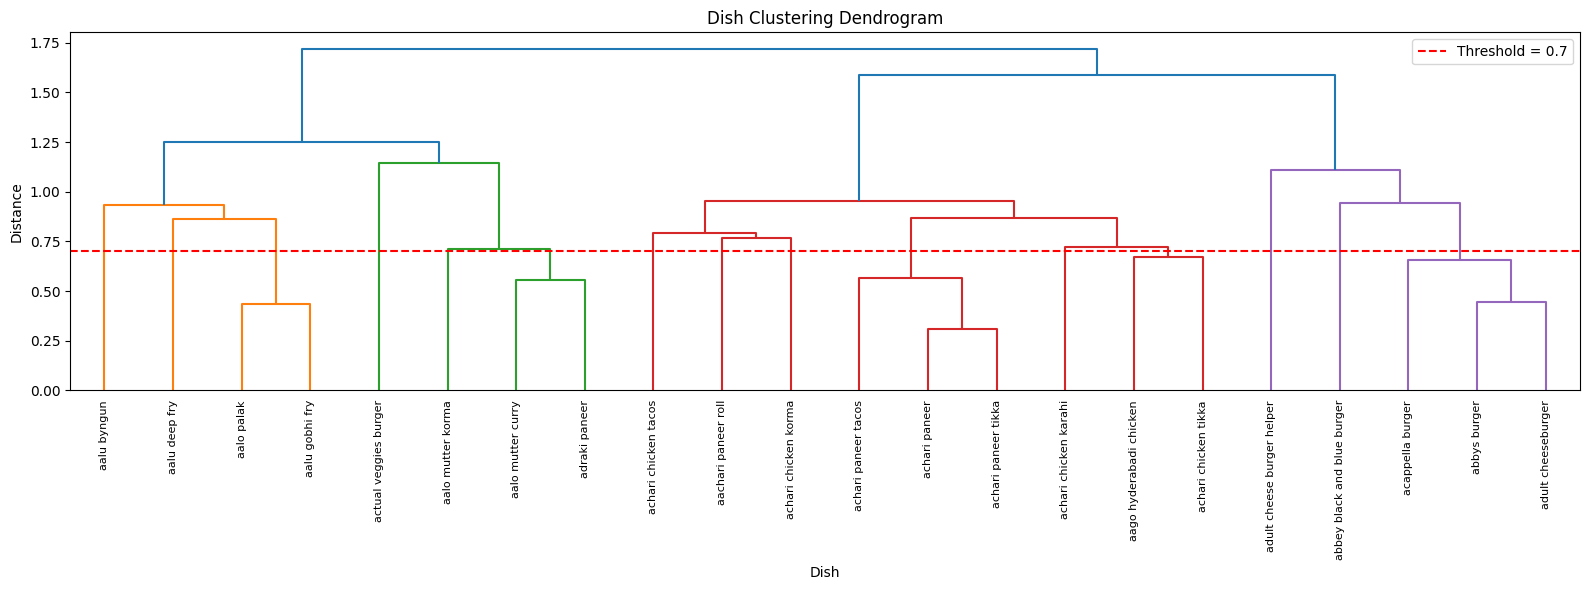

In [21]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
Z = linkage(combined_dist, method='average') 

dish_names = flavor_features['dish_name'].tolist()

plt.figure(figsize=(16, 6))
dendrogram(Z, labels=dish_names, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=threshold, c='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.title('Dish Clustering Dendrogram')
plt.xlabel('Dish')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [19]:
for cluster_id, group in flavor_features.groupby('cluster'):
    print(f"Cluster {cluster_id}:")
    print(group['dish_name'].tolist())
    print()

Cluster 0:
['aachari paneer roll', 'aago hyderabadi chicken', 'aalo mutter curry', 'aalo mutter korma', 'aalo palak', 'aalu byngun', 'aalu deep fry', 'aalu gobhi fry', 'achari chicken karahi', 'achari chicken korma', 'achari chicken tacos', 'achari chicken tikka', 'achari paneer', 'achari paneer tacos', 'achari paneer tikka', 'actual veggies burger', 'adraki paneer']

Cluster 1:
['abbey black and blue burger', 'abbys burger', 'acappella burger', 'adult cheese burger helper', 'adult cheeseburger']

